### In this notebook, we will explore the following questions: 
 - Is there a relationship between the number of installs and the number of user ratings? Does it matter if we consider a different range in the number of installs?
 - Are apps 'getting better'? Are the ratings and the number of reviews higher for newer apps? Why or why not?
 - Are there trends in the number of user ratings for each developer? (Namely, if a developer publishes a "popular" app, do their subsequent apps become more popular due to the increased recognition/exposure?)

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import ipywidgets as widgets
import plotly.express as px
import plotly.offline as pyo
import re
from datetime import datetime
import calendar 

In [2]:
sns.set()
palette = sns.color_palette('Set2')

# From https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 400)

In [3]:
apps = pd.read_csv(r'Google Play Store Apps.zip')
apps.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-and-conditions/privacy-policy,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UCS548,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [4]:
apps.shape

(2312944, 24)

In [5]:
# Drop invalid entry and irrelevant columns to current analysis
columns = ['Minimum Android', 'Developer Email', 'Last Updated', 'Developer Website', 'Developer Email', 
           'Content Rating', 'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice', 'Scraped Time']
apps.drop(columns=columns, inplace=True)

In [6]:
apps.dropna(subset=['Installs', 'Rating Count'], inplace=True)

In [7]:
# Remove the '+' at the end of the Installs entry so they can be numerically sorted 
# Also remove the ',' separating the numbers
apps['Installations'] = apps['Installs'].str.replace(r'\+|,', '')
apps['Installations'] = apps['Installations'].astype(int)

<ipython-input-7-68a00ffdbcd3>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



Let's see a distrubtion of the number of installations. 

In [8]:
grouped_installs = apps.groupby(by=['Installs', 'Installations']).count()
grouped_installs.reset_index(inplace=True)

In [9]:
grouped_installs.sort_values(by=['Installations'], inplace=True)

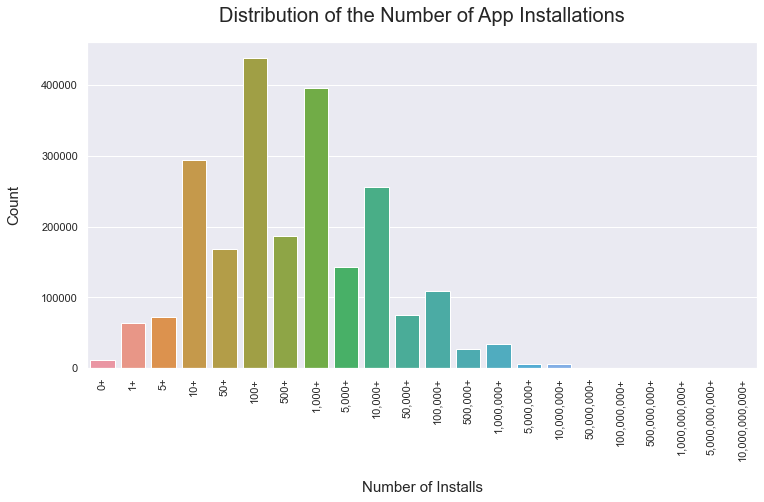

In [10]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()
sns.barplot(x='Installs', y='App Name', data=grouped_installs)
plt.xlabel('Number of Installs', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.title('Distribution of the Number of App Installations', fontsize=20, pad=20)
plt.xticks(rotation=90)
plt.show()

We suppose that (virtually) all apps have at least one install because its own developer would presumbly install it themselves for testing purposes. Although it is interesting to note that, despite the increasing interval size (we do not have access to the exact number of installs from the data), there is no evident monotonically increasing or decreasing trend. We thought that, as a consequence of the invervals increasing in size, a larger interval could "cover" more apps, so there would be an increasing trend. But we can observe that the number of apps in each 'bucket' alternates between increasing and decreasing from 5+ to 5,000,000+.

In [11]:
def plot_installs_and_reviews(apps, show=True):
    figure = plt.figure(figsize=(12, 6))
    axis = plt.gca()
    # From https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot
    axis.ticklabel_format(style='plain')

    sns.scatterplot(x=apps['Maximum Installs'], y=apps['Rating Count'], data=apps, alpha=0.6)
    plt.xlabel('Number of Installs', fontsize=15, labelpad=20)
    plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
    plt.title('Number of Reviews Against the Number of Installs for Apps', fontsize=20, pad=20)
    plt.xticks(rotation=90)

    if show: 
        plt.show()

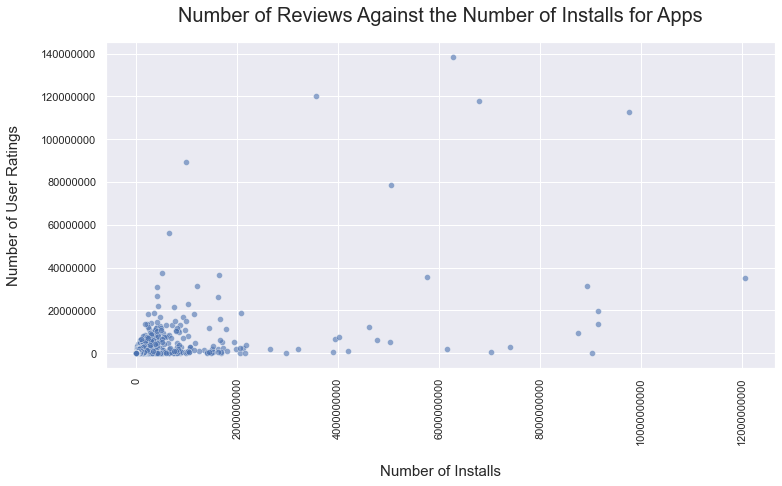

In [12]:
plot_installs_and_reviews(apps)

Visually, we can see that most of the data have less than 500000 (approx) installs. Let's consider only those data points and remove obvious outliers. 

There are also some apps with 0 installations but with several reviews. Either some people rated the application without downloading or the installation count is not updated. We should not consider these data points. 

We should also remove data points that have more reviews than installations. 

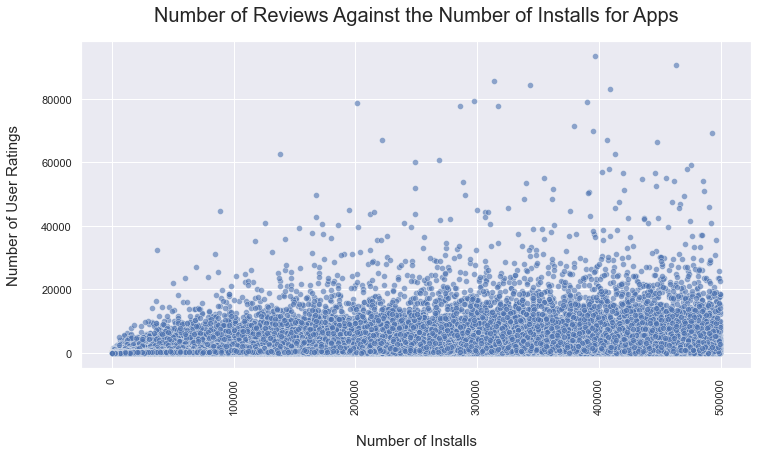

In [13]:
apps = apps[apps['Maximum Installs'] > apps['Rating Count']]
filtered_apps = apps[(apps['Maximum Installs'] < 500000) & (apps['Rating Count'] < 100000)].copy()
plot_installs_and_reviews(filtered_apps)

In [14]:
fit = stats.linregress(filtered_apps['Maximum Installs'], filtered_apps['Rating Count'])
filtered_apps['prediction'] = filtered_apps['Maximum Installs']*fit.slope + fit.intercept

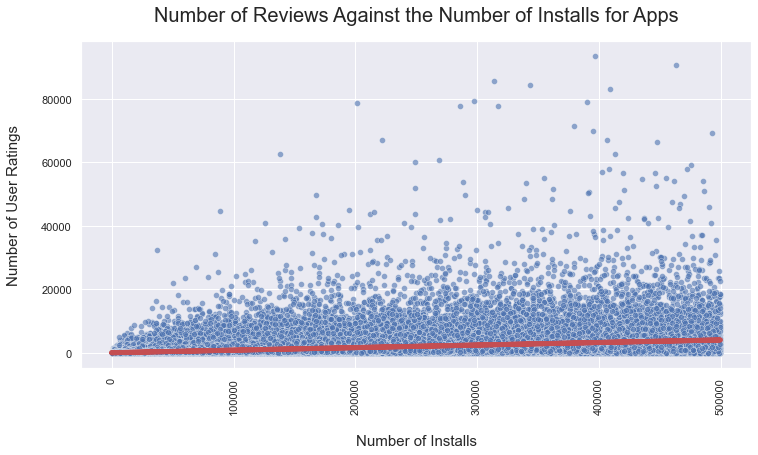

In [15]:
plot_installs_and_reviews(filtered_apps, show=False)
plt.plot('Maximum Installs', 'prediction', data=filtered_apps, color='r', linewidth=5)
plt.show()

In [16]:
fit.pvalue, fit.slope

(0.0, 0.008065716829528157)

With such a small pvalue, we can strongly reject the null hypothesis that the slope is 0 and conclude that more installs is linearly associated with more reviews. But the slope is not very high. It is only increase ever so slightly. 

But what if we only consider apps with less than 1000 installs?

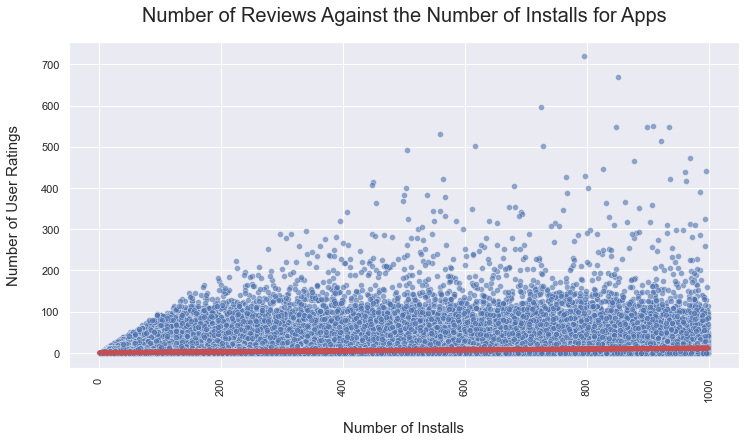

In [17]:
filtered_sample = filtered_apps[filtered_apps['Maximum Installs'] < 1000].copy()
fit = stats.linregress(filtered_sample['Maximum Installs'], filtered_sample['Rating Count'])
filtered_sample['prediction'] = filtered_sample['Maximum Installs']*fit.slope + fit.intercept

plot_installs_and_reviews(filtered_sample, show=False)
plt.plot('Maximum Installs', 'prediction', data=filtered_sample, color='r', linewidth=5)
plt.show()

In [18]:
fit.pvalue, fit.slope

(0.0, 0.011322638880374344)

The slope is still very close to 0. 

Next, we return to the original data set and compute a correlation coefficient. 

In [19]:
r, p_value= stats.pearsonr(apps['Rating Count'], apps['Installations'])
r, p_value

(0.5452811587920685, 0.0)

With a p-value is 0, we know that the probability of observing the given results if the correlation coefficient was actually 0, is virtually 0. There does exists some positive linear association between the number of installs and the number of reviews. 

We proceed to investigate our next question: Are the number of app ratings increasing for newer apps?

In [20]:
apps.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Developer Id,Released,Installations
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,Jean Confident Irénée NIYIZIBYOSE,"Feb 26, 2020",10
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,Webserveis,"May 21, 2020",5000
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,Cabin Crew,"Aug 9, 2019",50
3,Smart City Trichy Public Service Vehicles 17UCS548,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,Climate Smart Tech2,"Sep 10, 2018",10
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,Rafal Milek-Horodyski,"Feb 21, 2020",100


Let's start with a simple histogram of app ratings. Apps that are not rated have a rating of "0", but let us consider apps that are rated for now because the majority of apps are not rated, which would interfere with the scaling of the histogram. 

In [21]:
apps = apps[apps['Rating Count'] > 0]

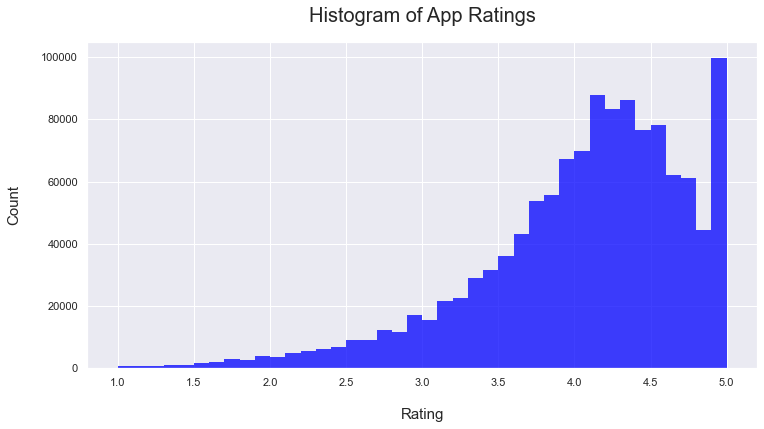

In [22]:
figure = plt.figure(figsize=(12, 6))
sns.histplot(x='Rating', data=apps, color='blue', binwidth=0.1, edgecolor='none')

plt.xlabel('Rating', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.title('Histogram of App Ratings', fontsize=20, pad=20)

plt.show()

So it seems that the majority of ratings are 4 or higher.

Let's take a closer look by analying the average app rating via month. 

In [23]:
pattern = re.compile('^(.*)\s\d+,\s(\d{4})$')
def extract_month_and_year(date): 
    match = pattern.match(date)
    if match: 
        return str(datetime.strptime(match[1], '%b').month) + ', ' + str(match[2])
    else:
        return np.nan 

In [24]:
apps = apps.dropna(subset=['Released'])

# Custom function to extract month and year
apps['Release Month/Year'] = apps['Released'].apply(lambda x: extract_month_and_year(str(x)))

# From https://stackoverflow.com/questions/14745022/how-to-split-a-dataframe-string-column-into-two-columns
apps[['Release Month', 'Release Year']] = apps['Release Month/Year'].str.split(',', 1, expand=True)

In [25]:
grouped_dates = apps.groupby(by=['Release Year', 'Release Month'], sort=False)
grouped_dates = grouped_dates.agg(average_rating=('Rating', 'mean'), 
                                  count_apps_published=('Rating', 'count'),
                                  average_num_ratings=('Rating Count', 'mean'))

grouped_dates.reset_index(inplace=True)

In [26]:
grouped_dates['Release Year'] = grouped_dates['Release Year'].astype('int')
grouped_dates['Release Month'] = grouped_dates['Release Month'].astype('int')

grouped_dates.sort_values(by=['Release Year', 'Release Month'], inplace=True)

In [27]:
grouped_dates['Release Month'] = grouped_dates['Release Month'].apply(lambda x: calendar.month_abbr[int(x)])

# Conver to a non-numeric month format for plotting
grouped_dates['Release Year'] = grouped_dates['Release Year'].astype('str')
grouped_dates['Release Month'] = grouped_dates['Release Month'].astype('str')
grouped_dates['Release Month/Year'] = grouped_dates['Release Month'] + ' ' + grouped_dates['Release Year']

In [28]:
grouped_dates.head()

,Release Year,Release Month,average_rating,count_apps_published,average_num_ratings,Release Month/Year
137,2010,Jan,3.907692,26,30140.461538,Jan 2010
136,2010,Feb,3.873050,141,64865.418440,Feb 2010
89,2010,Mar,3.916143,223,16112.470852,Mar 2010
131,2010,Apr,3.957426,202,128843.811881,Apr 2010
119,2010,May,4.015198,329,45196.030395,May 2010


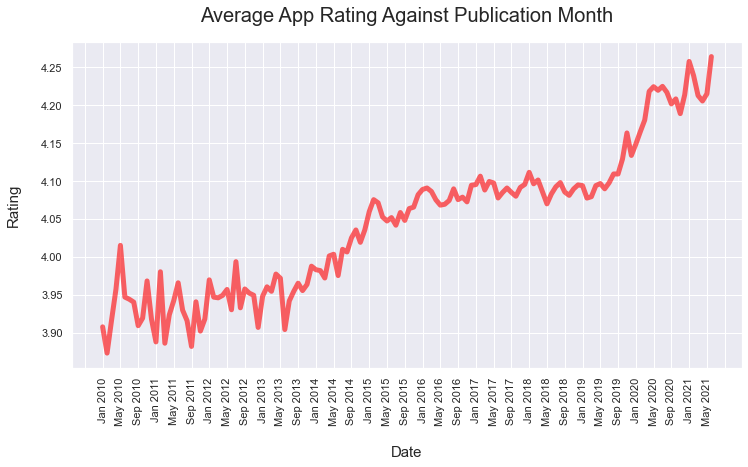

In [29]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()
plt.plot(grouped_dates['Release Month/Year'], grouped_dates['average_rating'], linewidth=5, color='red', alpha=0.6)
plt.xlabel('Date', fontsize=15, labelpad=20)
plt.ylabel('Rating', fontsize=15, labelpad=20)
plt.xticks(rotation=90)
plt.title('Average App Rating Against Publication Month', fontsize=20, pad=20)

# From https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
# Reduce the number of x-ticks
axis.xaxis.set_major_locator(plt.MaxNLocator(40))
plt.show()

In [30]:
# Need to install pymannkendall: sudo pip install pymannkendall
# From https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install pymannkendall

We proceed to perform the Mann-Kendall Test to test for an increasing or decreasing trend in the rating of apps. 

Null hypothesis: There does not exist an increasing or decreasing trend 

Alternative hypothesis: There does exist an increasing or decreasing trend

In [31]:
# Inspired from https://pypi.org/project/pymannkendall/
import pymannkendall as mk

trend, h, pvalue, z, Tau, s, var_s, slope, intercept = mk.original_test(grouped_dates['average_rating'])
trend, pvalue

('increasing', 0.0)

Indubitably, from the test, we can reject the null hypothesis and conclude that there does exist a trend in the number of app ratings -- particularly an increasing one. 

Why is this happening? Are apps getting "better"?

Let's see a histogram of the number of apps published by month. 

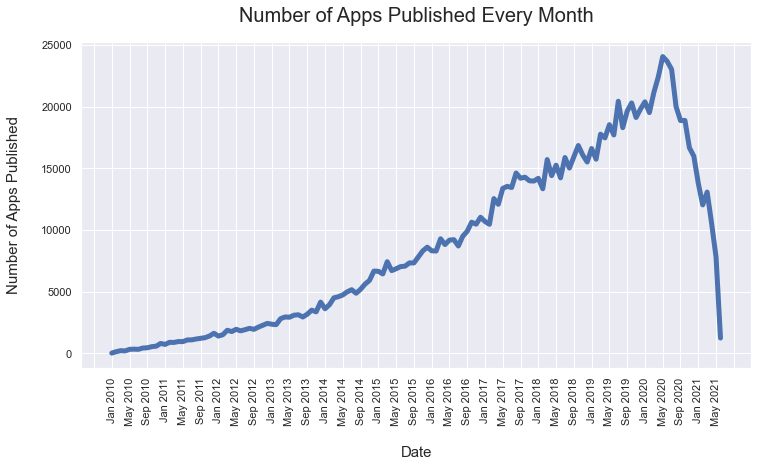

In [32]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()
plt.plot(grouped_dates['Release Month/Year'], grouped_dates['count_apps_published'], linewidth=5)
plt.xlabel('Date', fontsize=15, labelpad=20)
plt.ylabel('Number of Apps Published', fontsize=15, labelpad=20)
plt.xticks(rotation=90)
plt.title('Number of Apps Published Every Month', fontsize=20, pad=20)

# From https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
# Reduce the number of x-ticks
axis.xaxis.set_major_locator(plt.MaxNLocator(40))
plt.show()

It appears that progressively more apps are being published every month. One speculation is that as more apps are published, users rate more. And a histogram of app ratings showed that the majority of ratings are higher than 4. 

(Side note: The large dip at the end of the graph seems align with the onset of the Covid-19 pandemic. Perhaps the pandemic impacted the number of applications a studio could publish?)

Ok, so more apps are being published over time (generally). Does that mean users are actually rating these apps more? Let's look at the average number of user ratings compared to each app's publication month.  

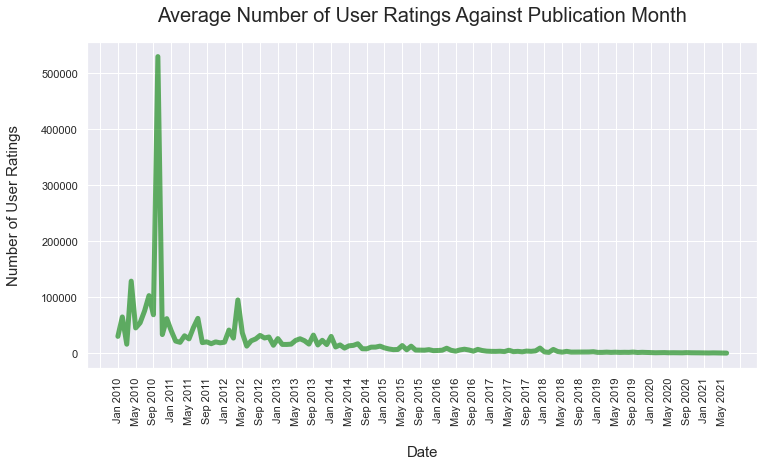

In [33]:
def plot_count_user_ratings(grouped_dates):
    figure = plt.figure(figsize=(12, 6))
    axis = plt.gca()
    plt.plot(grouped_dates['Release Month/Year'], grouped_dates['average_num_ratings'], linewidth=5, alpha=0.6, color='green')
    plt.xlabel('Date', fontsize=15, labelpad=20)
    plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
    plt.xticks(rotation=90)
    plt.title('Average Number of User Ratings Against Publication Month', fontsize=20, pad=20)

    # From https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
    # Reduce the number of x-ticks
    axis.xaxis.set_major_locator(plt.MaxNLocator(40))
    plt.show()

plot_count_user_ratings(grouped_dates)

Apps published in early 2010 have an unusally large number of user ratings. Let's investigate that data point. 

In [34]:
grouped_dates.reset_index(inplace=True)
high_num_rating = grouped_dates.iloc[grouped_dates['average_num_ratings'].idxmax()]
high_num_rating_month = str(datetime.strptime(high_num_rating['Release Month'], '%b').month)
high_num_rating_year = int(high_num_rating['Release Year'].strip())

In [35]:
apps['Release Year'] = apps['Release Year'].astype(int)
high_num_rating_apps = apps[(apps['Release Month'] == high_num_rating_month) &
                                 (apps['Release Year'] == high_num_rating_year)].copy()

In [36]:
high_num_rating_apps.sort_values(by=['Rating Count'], ascending=False, inplace=True)
top_ten = high_num_rating_apps.head(10)

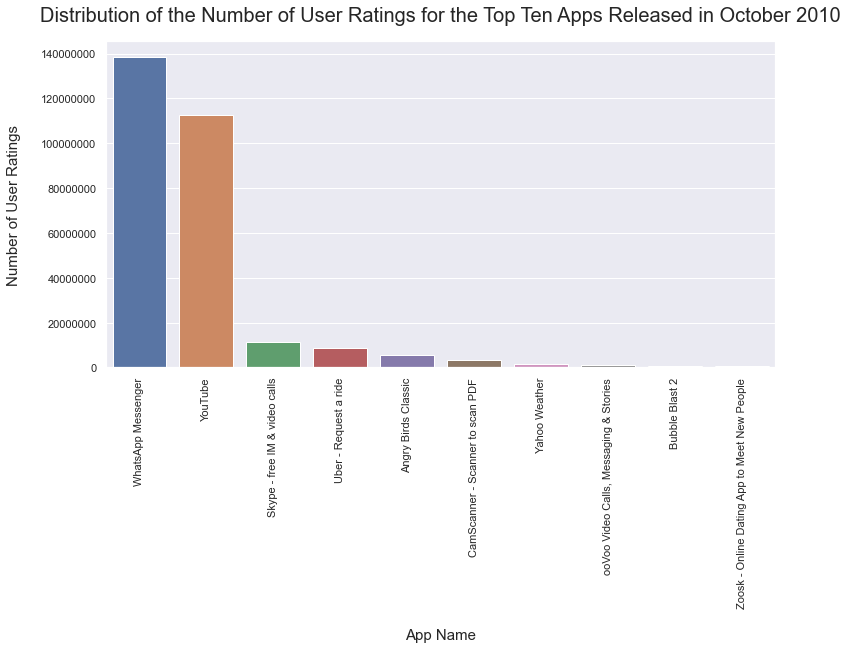

In [37]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()

# From https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot
axis.ticklabel_format(style='plain')

sns.barplot(x='App Name', y='Rating Count', data=top_ten)
plt.xticks(rotation=90)
plt.xlabel('App Name', fontsize=15, labelpad=20)
plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
plt.title('Distribution of the Number of User Ratings for the Top Ten Apps Released in October 2010', fontsize=20, pad=20)
plt.show()

We can see that the usually large mean number of user ratings in the October of 2010 is attributed to two particular apps: WhatsApp and YouTube. These apps are immensely popular so there is no surprise that they have millions of ratings. 

What if we consider 2013 onward? There (visably) seems to be a plateau in the graph after this point. 

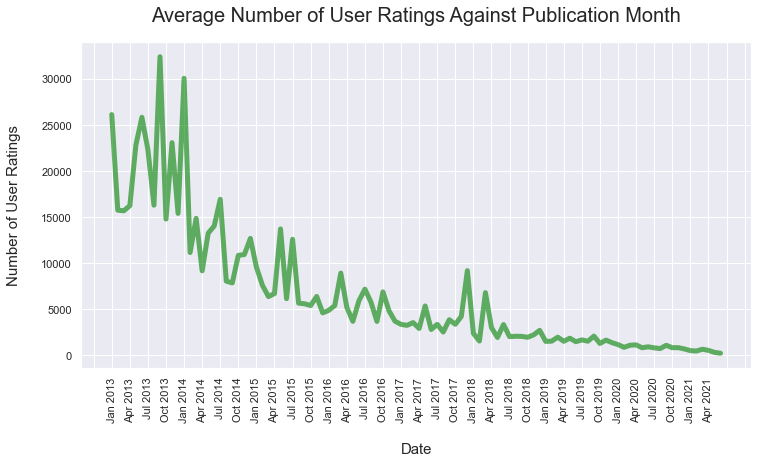

In [38]:
grouped_dates['Release Year'] = grouped_dates['Release Year'].astype(int)
grouped_dates = grouped_dates[grouped_dates['Release Year'] >= 2013]

plot_count_user_ratings(grouped_dates)

Interesting. Although more and more apps are being published over time, the newer apps presumably have not had enough time to acquire as many ratings as the older ones, so there is a decreasing trend. But the average app rating is increasing over time despite the increase in the number of published apps which, as a consequence, have a lower number of ratings.  

So does that mean apps with less ratings have higher ratings? As we demonstrated with the previous histogram, there are much more higher ratings than lower ratings on the Google Play Store. Perhaps the less ratings an app has the less likely it is to "contain" a negative one. 

Let's consider two groups: apps that have less than or equal to 30 ratings or more than 30 ratings. Are their ratings different? 

In [39]:
less_thirty = apps[apps['Rating Count'] <= 30]
more_thirty = apps[apps['Rating Count'] > 30]

In [40]:
# Verify that both are normallity distributed
less_thirty_p = stats.normaltest(less_thirty['Rating']).pvalue
more_thirty_p = stats.normaltest(more_thirty['Rating']).pvalue
less_thirty_p, more_thirty_p

(0.0, 0.0)

We proceed to use the Mann–Whitney U test to compare the means of the two groups because they are not normally distributed. 

In [41]:
stats.mannwhitneyu(more_thirty['Rating'], less_thirty['Rating'])

MannwhitneyuResult(statistic=152703111792.0, pvalue=0.0)

With an extremely small p-value, we reject the null hypothesis that they come from the same distribution -- hence the mean rating for apps with less than or equal to 30 ratings is different than the mean rating for apps with more than 30 ratings. 

Indeed, if we look at the means of our sample, we can see that the mean rating of apps that have more than 30 ratings is lower:

In [42]:
np.mean(less_thirty['Rating']), np.mean(more_thirty['Rating'])

(4.1670382721472565, 4.051956298764839)

Ok, so apps with less reviews have higher ratings, on average. But if the app is not rated by many people, we would not consider it as "sucessful" as an application that has millions of reviews even if their rating is not as high!

Let's look at apps that have the fastest review-acqusition rate. We will look at how many reviews an app has and take into account when it was published. 

In [43]:
pd.to_datetime('today').date().year

2021

In [44]:
def get_app_lifetime(publish_date, today):
    res = publish_date.split(',')
    month = int(res[0])
    year = int(res[1])
    current_month = today.month
    current_year = today.year
    
    year_diff = current_year - year 
    month_diff = current_month - month 
    
    return 12 * year_diff + month_diff

In [45]:
today = pd.to_datetime('today').date()
apps['App Lifetime'] = apps['Release Month/Year'].apply(lambda x: get_app_lifetime(x, today))

We will take the number of months that the app has been on the market and divide by the number of reviews. This is the number of reviews that the app gets per month on average. 

We do not have access to how an app acquires review over a period of time unfortunately, so this is the best approximate that we can work with, although the average is a cruel statistic. 

In [46]:
apps['Reviews Per Month'] = apps['Rating Count'] / apps['App Lifetime']

In [47]:
apps_dev_grouped = apps.groupby(by=['Developer Id']).sum('Reviews Per Month').reset_index()
apps_dev_grouped.sort_values(by=['Reviews Per Month'], ascending=False, inplace=True)
apps_dev_grouped = apps_dev_grouped.head(10)

A new tab should open of a plotly treemap of 50 apps with the highest number of reviews per month. 

We've also categorized them by developer and select their top ten performing apps for the purposes of visualization. 

In [48]:
# Get back the app name
apps_dev_grouped = apps_dev_grouped.merge(apps[['Developer Id', 'App Name']], on=['Developer Id'], how='inner')

In [49]:
top_apps_dev_grouped = apps_dev_grouped.groupby(by=['Developer Id'], sort=False).head(10)

In [90]:
# Referenced https://www.youtube.com/watch?v=YDHjHcKzeeE
fig = px.treemap(top_apps_dev_grouped, path=[px.Constant('Developer'), 'Developer Id', 'App Name'], values='Reviews Per Month')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin=dict(t=25, l=25, r=25, b=50), font={'size': 20})
pyo.plot(fig)

'temp-plot.html'

There are a few developers that dominant the app market with their applications, namely Google and Facebook. Their applications have been published years ago, and still retain millions of users, which attributes to their exoribitant number of average monthly reviews. With these apps on the market, despite an influx in the number of newer apps, the "average" number of ratings for older apps will still be higher. 

Speaking of developers, we will further investigate the publication trend for each developer: do the number of user ratings increase over time for apps published by the same developer?

In [51]:
grouped_apps = apps.groupby(by=['Developer Id']).count()

In [52]:
# Only include developers who have published more than 50 apps (If a developer does not publish many apps, it is not worth investigating)
grouped_apps = grouped_apps[grouped_apps['App Id'] > 50]
grouped_apps = grouped_apps.reset_index()

In [53]:
apps = apps.merge(right=grouped_apps['Developer Id'])
apps['Released'] = pd.to_datetime(apps['Released']).dt.date
apps.sort_values(by=['Released'], inplace=True)

In [54]:
# Custom aggregate to reverse-explode (implode) 
# Column 1  Column 2       Column 1     Column 2
#   a          6            a            [6, 7]
#   a          7       =>   b              [8] 
#   b          8

def implode(series): 
    return series.to_list()

In [55]:
imploded_apps = apps.groupby('Developer Id', sort=False).agg({'Rating Count': [implode], 'Released': [implode]})
imploded_apps.reset_index(inplace=True)
imploded_apps.head()

,Developer Id,Rating Count,Released
,,implode,implode
0,SeeClickFix,"[1428.0, 111.0, 197.0, 62.0, 133.0, 6.0, 9.0, 110.0, 33.0, 10.0, 57.0, 12.0, 16.0, 271.0, 26.0, 30.0, 10.0, 50.0, 8.0, 9.0, 8.0, 43.0, 37.0, 5.0, 91.0, 10.0, 14.0, 8.0, 5.0, 9.0, 77.0, 7.0, 8.0, 7.0, 16.0, 11.0, 54.0, 16.0, 12.0, 6.0, 10.0, 7.0, 6.0, 14.0, 28.0, 24.0, 23.0, 19.0, 5.0, 46.0, 5.0, 13.0, 11.0, 44.0, 18.0, 8.0, 9.0, 5.0, 11.0, 7.0, 8.0, 5.0, 17.0, 55.0, 7.0, 14.0, 15.0, 7.0, 15.0,...","[2010-02-04, 2012-07-17, 2012-10-26, 2013-01-23, 2013-02-27, 2013-03-19, 2013-05-03, 2013-08-16, 2013-10-18, 2013-11-12, 2013-11-12, 2014-04-04, 2014-05-12, 2014-05-21, 2014-05-21, 2014-07-14, 2014-07-14, 2014-07-22, 2014-08-06, 2014-08-14, 2014-09-08, 2014-09-10, 2014-09-11, 2014-10-16, 2014-11-10, 2014-12-04, 2014-12-17, 2014-12-17, 2015-02-06, 2015-05-04, 2015-05-11, 2015-06-02, 2015-07-27,..."
1,Kittehface Software,"[61.0, 69427.0, 7496.0, 8859.0, 1358.0, 11784.0, 167295.0, 603.0, 11214.0, 8148.0, 502.0, 139.0, 3043.0, 897.0, 447.0, 116295.0, 9375.0, 451.0, 2355.0, 1582.0, 957.0, 9697.0, 559.0, 11919.0, 64444.0, 29443.0, 25307.0, 730.0, 1718.0, 16727.0, 17614.0, 408.0, 1670.0, 23609.0, 1019.0, 92.0, 37.0, 303.0, 2165.0, 592.0, 106.0, 721.0, 292812.0, 14764.0, 127.0, 601.0, 5235.0, 184.0, 24.0, 42.0, 3389....","[2010-02-10, 2010-03-18, 2010-03-18, 2010-03-22, 2010-03-22, 2010-04-13, 2010-04-13, 2010-05-02, 2010-05-02, 2010-05-15, 2010-05-15, 2010-05-30, 2010-06-28, 2010-07-29, 2010-08-16, 2010-08-20, 2010-08-20, 2010-09-02, 2010-09-02, 2010-09-12, 2010-09-22, 2010-09-22, 2010-10-15, 2010-10-25, 2010-10-25, 2010-11-15, 2010-11-16, 2010-11-17, 2010-12-01, 2010-12-01, 2010-12-28, 2010-12-28, 2011-02-13,..."
2,SpeedyMarks,"[27.0, 61.0, 53.0, 70.0, 37.0, 22.0, 45.0, 94.0, 42.0, 13.0, 8.0, 102.0, 10.0, 1257.0, 67.0, 203.0, 8.0, 9.0, 90.0, 17.0, 476.0, 41.0, 35.0, 125.0, 9.0, 6.0, 9.0, 5.0, 26.0, 86.0, 11.0, 16.0, 861.0, 133.0, 9.0, 10.0, 6.0, 5.0, 15.0, 185.0, 41.0, 17.0, 14.0, 11.0, 8.0, 9.0, 20.0, 5.0, 20.0, 26.0, 11.0, 38.0, 65.0, 39.0, 28.0, 16.0, 24.0, 118.0, 12.0]","[2010-02-11, 2010-02-12, 2010-03-02, 2010-03-19, 2010-03-19, 2010-03-19, 2010-03-20, 2010-08-24, 2010-09-17, 2010-09-27, 2010-12-01, 2011-01-27, 2011-01-27, 2011-01-29, 2011-03-04, 2011-03-10, 2011-03-15, 2011-03-16, 2011-03-18, 2011-03-22, 2011-03-26, 2011-05-06, 2011-06-28, 2011-08-23, 2011-09-06, 2011-10-21, 2011-10-25, 2011-11-07, 2011-11-24, 2012-05-11, 2012-05-11, 2012-05-15, 2012-06-05,..."
3,Google LLC,"[601272.0, 19798962.0, 2311151.0, 9488421.0, 74002.0, 3503.0, 112440547.0, 85548.0, 1814775.0, 157003.0, 639307.0, 1825673.0, 1059837.0, 6359366.0, 8287.0, 31481796.0, 316696.0, 35128398.0, 2599.0, 201058.0, 126343.0, 1685331.0, 1381263.0, 357647.0, 615596.0, 1212098.0, 5072462.0, 24328.0, 667983.0, 1096419.0, 12016421.0, 254700.0, 4028.0, 80673.0, 2342971.0, 945163.0, 42506.0, 1538671.0, 1346...","[2010-02-22, 2010-08-12, 2010-09-09, 2010-09-21, 2010-10-04, 2010-10-08, 2010-10-20, 2010-10-28, 2010-12-06, 2011-02-03, 2011-04-27, 2011-06-03, 2011-06-24, 2011-06-28, 2011-11-04, 2012-02-07, 2012-03-21, 2012-05-24, 2012-06-27, 2012-06-27, 2012-06-29, 2012-10-17, 2012-12-06, 2012-12-12, 2013-02-27, 2013-03-20, 2013-05-15, 2013-05-29, 2013-06-05, 2013-07-18, 2013-07-24, 2013-10-10, 2013-10-14,..."
4,Smarter Agent,"[126.0, 76.0, 154.0, 154.0, 28.0, 168.0, 97.0, 45.0, 9.0, 69.0, 6.0, 29.0, 729.0, 5.0, 38.0, 9.0, 6.0, 239.0, 49.0, 8.0, 48.0, 13.0, 9.0, 6.0, 12.0, 14.0, 17.0, 14.0, 14.0, 12.0, 6.0, 15.0, 14.0, 5.0, 9.0, 5.0, 5.0, 23.0, 12.0, 41.0, 10.0, 6.0, 9.0, 11.0, 12.0, 8.0, 19.0, 13.0, 7.0, 9.0, 13.0, 9.0, 47.0, 13.0, 6.0, 26.0, 11.0, 12.0, 17.0, 5.0, 9.0, 6.0, 6.0, 8.0]","[2010-02-25, 2011-11-03, 2011-11-03, 2011-12-13, 2012-02-02, 2012-03-30, 2012-06-05, 2012-12-17, 2013-02-05, 2013-02-05, 2013-02-05, 2013-03-11, 2013-04-22, 2013-05-29, 2013-07-10, 2014-03-28, 2014-05-23, 2014-07-28, 2014-10-13, 2014-11-06, 2015-01-09, 2015-04-10, 2015-12-13, 2015-12-16, 2015-12-29, 2016-02-02, 2016-02-24, 2016-

In [56]:
# Need to install pymannkendall: sudo pip install pymannkendall
# From https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install pymannkendall

We proceed to perform the Mann-Kendall Test to test for an increasing or decreasing trend in the number of user ratings for each developer. 

Null hypothesis: There does not exist an increasing or decreasing trend.

Alternative hypothesis: There does exist an increasing or decreasing trend.

In [57]:
# Inspired from https://pypi.org/project/pymannkendall/
def test_mannkendall(ratings):
    
    trend, h, pvalue, z, Tau, s, var_s, slope, intercept = mk.original_test(ratings)
    return str(trend) + ', ' + str(pvalue)

In [58]:
imploded_apps['test_res'] = imploded_apps['Rating Count']['implode'].apply(lambda x: test_mannkendall(x))

In [59]:
# From https://stackoverflow.com/questions/14745022/how-to-split-a-dataframe-string-column-into-two-columns
imploded_apps[['trend', 'pvalue']] = imploded_apps['test_res'].str.split(',', 1, expand=True)

In [60]:
imploded_apps['pvalue'] = imploded_apps['pvalue'].astype(float)
significant_apps = imploded_apps[imploded_apps['pvalue'] < 0.05] 

In [61]:
len(significant_apps)

805

In [62]:
len(imploded_apps) - len(significant_apps)

609

In [63]:
len(significant_apps) / len(imploded_apps)

0.5693069306930693

This is the proportion of developers considered that exhibit a stastically significant trend in their app review counts. 

Let's compare the number apps that have an increasing trend against against ones that have a decreasing trend. 

In [64]:
decreasing_trend_apps = imploded_apps[imploded_apps['trend'] == 'decreasing'] 
increasing_trend_apps = imploded_apps[imploded_apps['trend'] == 'increasing']
len(decreasing_trend_apps), len(increasing_trend_apps)

(775, 30)

It seems that most apps that exhibit a statistically significant trend in the number of app ratings have a negative trend. 

In [65]:
significant_apps.set_index('Developer Id', inplace=True)

We plot the number of game ratings against publication date for developers that exhibit a statistically significant trend. Added a dropdown widget to toggle between different developers. 

In [66]:
def plot_trend(developer): 
    figure = plt.figure(figsize=(12,6))
    developer_info = significant_apps.loc[developer]

    dates = developer_info['Released']['implode']
    ratings = developer_info['Rating Count']['implode']
    axis = plt.gca()
    
    plt.plot(dates, ratings, linewidth=5)
    plt.xlabel('Date Published', fontsize=18, labelpad=40)
    plt.ylabel('Number of User Ratings', fontsize=18, labelpad=40)
    plt.xticks(rotation=90)
    plt.title('Developer: ' + developer + ' (Number of Game Ratings Against Publication date)', fontsize=25, pad=40)
    
    # From https://stackoverflow.com/questions/2969867/how-do-i-add-space-between-the-ticklabels-and-the-axes-in-matplotlib
    axis.tick_params(axis='x', which='major', pad=15, labelsize=15)
    axis.tick_params(axis='y', which='major', pad=15, labelsize=15)    
    plt.show()


In [67]:
dropdown = widgets.Dropdown(
    options=significant_apps.index,
    value=significant_apps.index[0], # Index stores all the developers
    description='Select a Developer: ',
    style={'description_width': 'initial'}
)

In [68]:
# Inspired from https://github.com/jupyter-widgets/ipywidgets/issues/2148
output = widgets.Output()

@output.capture()
def on_dropdown_change(change_info):
    output.clear_output()
    selected_developer = change_info['new']
    plot_trend(selected_developer)

In [69]:
# Plot the first item in the dropdown as default
with output: 
    plot_trend(significant_apps.index[0])

In [70]:
dropdown.observe(on_dropdown_change, names='value')

## Interactive Dropdown (run the code to use) 

In [71]:
display(dropdown)
display(output)

Dropdown(description='Select a Developer: ', options=('SeeClickFix', 'Kittehface Software', 'Google LLC', 'Sma…

Output()

## Remarks

Feel free to experiment with the dropdown menu to check out the trends in the number of game ratings for different developers.

It appears that most of trends that are statistically significant are decreasing, which is unexpected. However, we must also note that games published earlier have existed for longer and thus, had more time for users to generate ratings. We also acknowledgement the limitiation in the amount of data -- most developers do not publish many applications. 

